# Chi-Squared Calculation Comparison

This notebook compares the Chi-Squared values returned by SNCosmo against Chi-Squared values calculated manually.

In [2]:
%matplotlib inline

import sys
from warnings import warn

import numpy as np
import sncosmo
from SNData.csp import dr3
from SNData.des import sn3yr
from astropy.table import Table, join
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
from analysis_pipeline import get_fit_results, get_priors, SN91bgSource

for module in (dr3, sn3yr):
    module.download_module_data()
    module.register_filters(force=True)


## Manually Calculating Chi-Squared

In [90]:
def calc_chisq(data, model):
    """
    Calculate the chi-squared for a given data table and model
    
    Args:
        data  (Table): An SNCosmo input table
        model (Model): An SNCosmo Model
        
    Returns:
        The un-normalized chi-squared
        The number of data points used in the calculation
    """
    while(1):
        try:
            # Model flux and keep only non-zero values
            data['model_flux'] = [model.bandflux(b, t) for b, t in zip(data['band'], data['time'])]
            phase = data['time'] - model.parameters[1]
            #data = data[np.logical_and(phase < 50, phase > -20)]
            data = data[data['model_flux'] > 0]
            chisq = np.sum(((data['model_flux'] - data['flux']) / data['fluxerr']) ** 2)
            return chisq, len(data)
        except ValueError as err:
            # Remove bands that are out of model range
            data = data[data['band']!=err.args[0].split()[1][1:-1]]


In [82]:
#data.pprint(-1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: csp_dr3_Y, csp_dr3_H, csp_dr3_Ydw, csp_dr3_J(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


Chi-Squared from fit_lc: 1848.301057794406
Manual Chi-squared using all data: 1932.932683756744


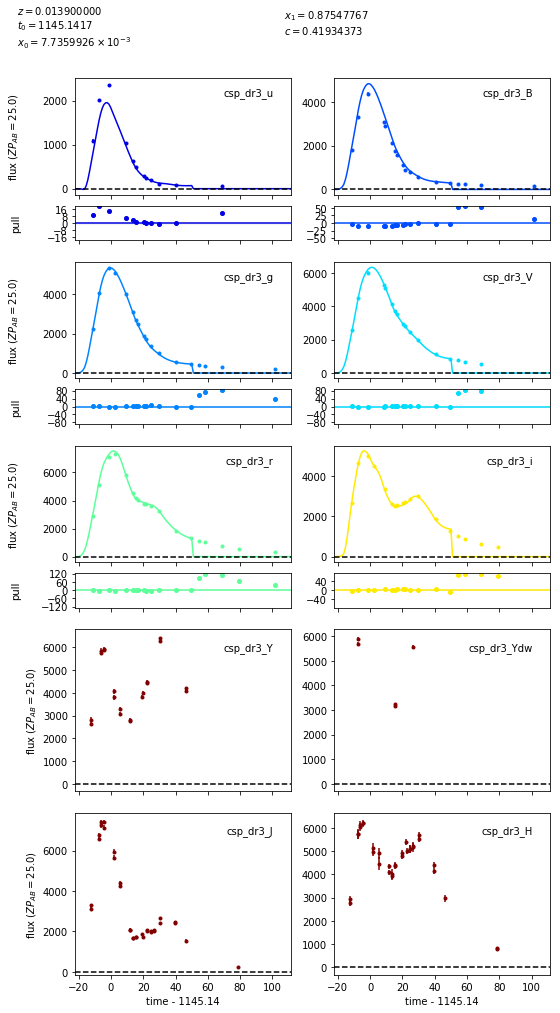

In [124]:
test_id = '2007S'
model = sncosmo.Model('salt2')
data = dr3.get_sncosmo_input(test_id)
priors = get_priors(dr3, model).loc[test_id]

model.set(z=data.meta['redshift'])
bounds = dict()
for p in model.param_names:
    bounds[p] = (priors[f'{p}_min'], priors[f'{p}_max'])
    model.update({p: priors[p]})

fit_result, fit_model = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'c'], bounds=bounds, phase_range=(-20,50))
sncosmo.plot_lc(data, fit_model)

full_sncosmo_chisq = fit_result['chisq'] #/ fit_result['ndof']
print('Chi-Squared from fit_lc:', full_sncosmo_chisq)

#func_chisq = sncosmo.chisq(data, model) / fit_result['ndof']
#print('Chi-Squared from `sncosmo.chisq`:', func_chisq)

man_chisq, num_points = calc_chisq(data, fit_model)
man_dof = fit_result['ndof'] - len(data) + num_points
print('Manual Chi-squared using all data:', man_chisq)# / man_dof)


In [125]:
allbands = data.copy()

Self-implemented lc-fitting plots

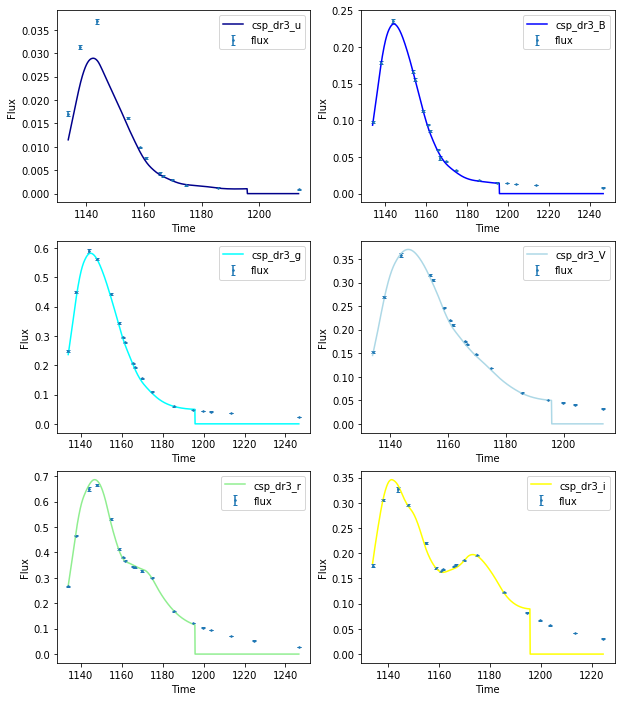

In [135]:
fig = plt.figure(figsize=(10,12))
ax = [plt.subplot(3,2,i+1) for i in range(6)]
b = ['csp_dr3_u','csp_dr3_B','csp_dr3_g','csp_dr3_V','csp_dr3_r','csp_dr3_i']
plot_color = ['darkblue', 'blue', 'aqua', 'lightblue', 'lightgreen', 'yellow']
for i in range(6):
    data = allbands.copy()
    data = data[data['band'] == b[i]]
    ax[i].errorbar(data['time'], data['flux'], yerr=data['fluxerr'], fmt='.', markersize=3, capsize=2)
    xtime = np.arange(data['time'].min(), data['time'].max(),0.1)
    yflux = [fit_model.bandflux(data['band'][0], t) for t in xtime]
    ax[i].plot(xtime, yflux, c=plot_color[i], label=b[i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Flux')
    ax[i].legend()

In [41]:
band_sncosmo_chisq = dict()
band_manual_chisq = dict()
for band in set(data['band']):
    band_data = data[data['band'] == band]
    try:
        fit_result, fitted_model = sncosmo.fit_lc(band_data, model, ['t0', 'x0', 'x1', 'c'], phase_range=(-15,50))
        
    except RuntimeError:
        continue
    
    
    # Calculate chi-squared
    man_chisq, num_points = calc_chisq(band_data, fitted_model)
    man_dof = fit_result['ndof'] - len(band_data) + num_points
    band_manual_chisq[band] = man_chisq / man_dof
    band_sncosmo_chisq[band] = fit_result['chisq'] / fit_result['ndof']

print('SNCosmo Chi-Squared:')
print(band_sncosmo_chisq)

print('\nManual Chi-Squared:')
print(band_manual_chisq)

print('\nSNCosmo Chi-Squared summed over bands:')
print(sum(i for i in band_sncosmo_chisq.values()))

print('\nManual Chi-Squared summed over bands:')
print(sum(i for i in band_manual_chisq.values()))

SNCosmo Chi-Squared:
{'csp_dr3_B': 1.4543085251722399, 'csp_dr3_r': 5.634601474431106, 'csp_dr3_g': 2.6893524327981075, 'csp_dr3_i': 6.984323381945437, 'csp_dr3_u': 1.1057966396195067, 'csp_dr3_V': 0.640924085217729}

Manual Chi-Squared:
{'csp_dr3_B': 152.35364546701703, 'csp_dr3_r': 12.22136458305663, 'csp_dr3_g': 17.338932375708342, 'csp_dr3_i': 11.918864895567218, 'csp_dr3_u': 13.904361719041765, 'csp_dr3_V': 12.83059464235603}

SNCosmo Chi-Squared summed over bands:
18.509306539184127

Manual Chi-Squared summed over bands:
220.56776368274703
